In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from typing import Literal

from matplotlib import pyplot as plt
from shapely.geometry import Point
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
import numpy as np

from s2shores.bathy_debug.spatial_dft_bathy_estimator_debug import SpatialDFTBathyEstimatorDebug

from s2shores.bathy_physics import celerity_offshore, period_offshore, wavelength_offshore
from s2shores.generic_utils.image_filters import circular_masking
from s2shores.generic_utils.image_utils import normalized_cross_correlation
from s2shores.generic_utils.signal_utils import find_period_from_zeros
from s2shores.generic_utils.symmetric_radon import symmetric_radon
from s2shores.image_processing.waves_radon import linear_directions
from s2shores.bathy_debug.display_utils import get_display_title_with_kernel
from s2shores.bathy_debug.sinogram_display import (
    build_sinogram_display, 
    build_sinogram_difference_display,
    build_sinogram_1D_display_master,
    build_sinogram_1D_cross_correlation,
    build_sinogram_1D_display_slave,
    build_sinogram_2D_cross_correlation,
)
from s2shores.bathy_debug.spatial_dft_wave_fields_display import build_dft_sinograms_spectral_analysis
from s2shores.bathy_debug.sinogram_display import (
    build_sinogram_display, 
    build_sinogram_difference_display,
    build_sinogram_spectral_display,
    build_correl_spectrum_matrix)

from s2shores.bathy_debug.spatial_dft_wave_fields_display import build_dft_sinograms
from s2shores.global_bathymetry.bathy_config import (
    BathyConfig,
    GlobalEstimatorConfig,
    SpatialDFTConfig,
)
from s2shores.waves_exceptions import WavesEstimationError, NotExploitableSinogram
from utils import initialize_sequential_run, read_config, plot_waves_row, build_ortho_sequence

### In case of a specfic server setup, specify the paths for 
```python
- os.environ["PROJ_DATA"]
- os.environ["GDAL_DATA"]
- os.environ["GDAL_DRIVER_PATH"]
- os.environ["CONDA_PREFIX"]
```

In [ ]:
"""
import os
os.environ["PROJ_DATA"]="..../share/proj"
os.environ["GDAL_DATA"]="..../share/gdal"
os.environ["GDAL_DRIVER_PATH"]="..../lib/gdalplugins"
os.environ["CONDA_PREFIX"]="..../s2shores"
"""

## Coastal Bathymetry Estimation via Spatial DFT

This notebook implements a bathymetric method using satellite imagery based on **spatial DFT** and the **linear relationship between water depth and wave kinematics**.  
Wave kinematics are inferred through the **spatial DFT of the wave field**, measured from two satellite images acquired within a short time interval.  
By leveraging the theory of linear wave dispersion in shallow water, bathymetry can be estimated from the wavelength of the waves.

## Notebook Objective

This notebook provides an **experimental and interactive** environment to:
- explore and adjust the key processing steps,
- quickly test different parameters and method variations,
- support **iterative development** of the processing workflow in a prototyping context.

## Notebook Summary

1. **Preprocess the images**: Apply filters on the images.
2. **Compute the Radon transforms**: Compute Radon transforms on all images.
3. **Find the directions**: Calculate the propagation directions of the waves.
4. **Prepare refinement**: Filter out and group found directions together.
5. **Find spectral peaks**: Compute the interpolated DFTs in each of the filtered directions and find the peaks.

In [3]:
base_path = Path("../TestsS2Shores").resolve()
test_case: Literal["7_4", "8_2"] = "8_2"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "spatial_dft"

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
config_path: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"

In [4]:
# config = read_config(config_path=config_path)

# OR

config = BathyConfig(
    GLOBAL_ESTIMATOR=GlobalEstimatorConfig(
        WAVE_EST_METHOD="SPATIAL_DFT",
        SELECTED_FRAMES=[10, 13],
        DXP=50,
        DYP=500,
        NKEEP=5,
        WINDOW=400,
        SM_LENGTH=100,
        MIN_D=2,
        MIN_T=3,
        MIN_WAVES_LINEARITY=0.01,
    ),
    SPATIAL_DFT=SpatialDFTConfig(
        PROMINENCE_MAX_PEAK=0.3,
        PROMINENCE_MULTIPLE_PEAKS=0.1,
        UNWRAP_PHASE_SHIFT=False,
        ANGLE_AROUND_PEAK_DIR=10,
        STEP_T=0.05,
    )
)

If you want to change any parameter of the configuration, modify the values of the object `config` by overriding the values of the attributes.  

Example:
```python
config.parameter = "new_value"
```

/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39321 instead
  warnings.warn(
/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


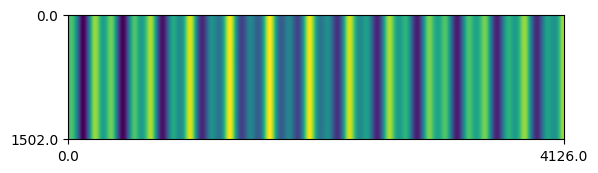

In [5]:
bathy_estimator, ortho_bathy_estimator = initialize_sequential_run(
    product_path=product_path,
    config=config,
    delta_time_provider=None,
)

plt_min = bathy_estimator.local_estimator_params['DEBUG']['PLOT_MIN']
plt_max = bathy_estimator.local_estimator_params['DEBUG']['PLOT_MAX']

In [6]:
estimation_point = Point(451.0, 499.0)

In [7]:
ortho_sequence = build_ortho_sequence(ortho_bathy_estimator, estimation_point)

selected_directions = linear_directions(
    angle_min=min(-180, plt_min),
    angle_max=max(180, plt_max),
    angles_step=1,
)

local_estimator = SpatialDFTBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
    selected_directions,
)

if not local_estimator.can_estimate_bathy():
    raise WavesEstimationError("Cannot estimate bathy.")

## Preprocess images

Modified attributes:
- local_estimator.ortho_sequence.\<elements\>.pixels

In [8]:
from s2shores.generic_utils.image_filters import desmooth, detrend

def custom_filter(img, param1, param2):
    """My custom filter."""
    return img


if False:
    local_estimator.preprocess_images()
else:
    preprocessing_filters = [(detrend, [])]

    if bathy_estimator.smoothing_requested:
        # FIXME: pixels necessary for smoothing are not taken into account, thus
        # zeros are introduced at the borders of the window.

        preprocessing_filters += [
            (desmooth,
             [bathy_estimator.smoothing_lines_size,
              bathy_estimator.smoothing_columns_size]),
            # Remove tendency possibly introduced by smoothing, specially on the shore line
            (detrend, []),
            # Add your custom filters here
            # Ex: (custom_filter, [param1, param2])
        ]

    
    for image in local_estimator.ortho_sequence:
        filtered_image = image.apply_filters(preprocessing_filters)
        image.pixels = filtered_image.pixels

## Display processed images

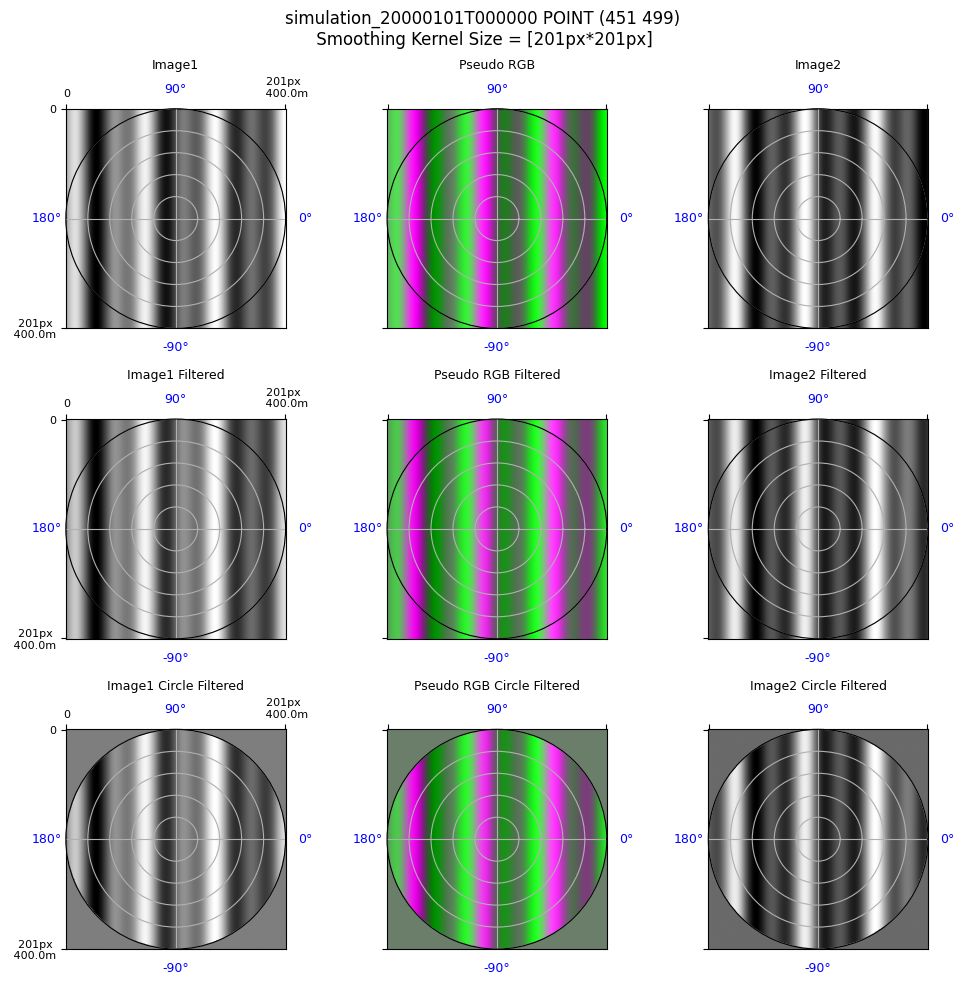

In [9]:
if False:
    build_waves_images_spatial_correl(local_estimator)
else:
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    # First Plot line = Image1 / pseudoRGB / Image2
    plot_waves_row(fig=fig,
                   axs=axs,
                   row_number=0,
                   pixels1=first_image.original_pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.original_pixels,
                   resolution2=first_image.resolution,
                   nrows=3,
                   ncols=3)
    # Second Plot line = Image1 Filtered / pseudoRGB Filtered/ Image2 Filtered
    plot_waves_row(fig=fig,
                   axs=axs,
                   row_number=1,
                   pixels1=first_image.pixels,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels, 
                   resolution2=first_image.resolution,
                   title_suffix=" Filtered",
                   nrows=3,
                   ncols=3)

    # Third Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    plot_waves_row(fig=fig,
                   axs=axs,
                   row_number=2,
                   pixels1=first_image.pixels * first_image.circle_image,
                   resolution1=first_image.resolution,
                   pixels2=second_image.pixels * second_image.circle_image, 
                   resolution2=first_image.resolution,
                   title_suffix=" Circle Filtered",
                   nrows=3,
                   ncols=3)
    plt.tight_layout()

## Compute radon transforms

New elements:
- local_estimator.radon_transforms

In [10]:
# Reset radon transforms when cell is re-run
local_estimator.radon_transforms = []
sampling_frequencies = []

if False:
    local_estimator.compute_radon_transforms()
    sampling_frequencies = [
        radon_transform.sampling_frequency
        for radon_transform in local_estimator.radon_transforms
    ]
else:
    for image in local_estimator.ortho_sequence:
        sampling_frequencies.append(1. / image.resolution)

        pixels = circular_masking(image.pixels.copy())
        radon_transform = symmetric_radon(image=pixels, theta=selected_directions)

        local_estimator.radon_transforms.append({
            direction: radon_transform[:, idx]
            for idx, direction in enumerate(selected_directions)
        })


## Plot sinograms

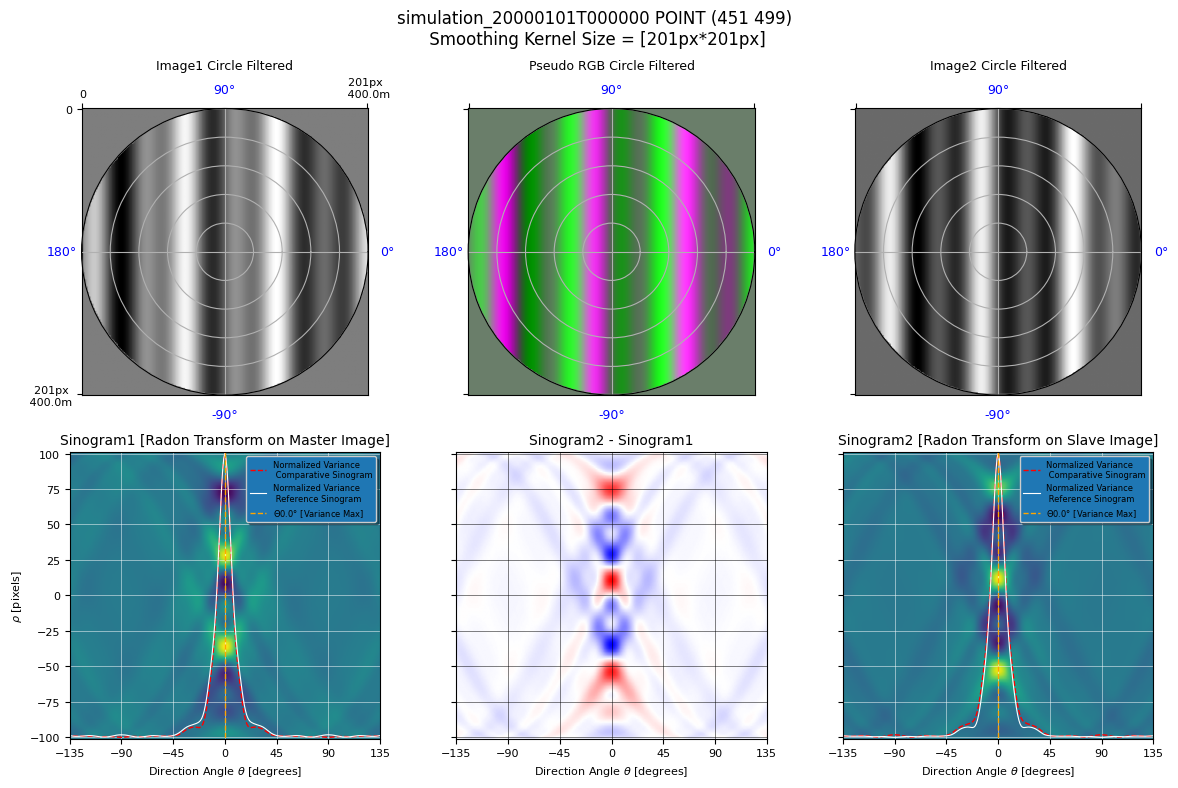

In [11]:
if False:
    # Use this when computing radon transforms with the standard method
    build_dft_sinograms(local_estimator)
else:
    nrows = 2
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)
    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    # First Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    plot_waves_row(
        fig=fig,
        axs=axs,
        row_number=0,
        pixels1=first_image.pixels * first_image.circle_image,
        resolution1=first_image.resolution,
        pixels2=second_image.pixels * second_image.circle_image,
        resolution2=first_image.resolution,
        nrows=nrows,
        ncols=ncols,
        title_suffix=" Circle Filtered",
    )

    # Second Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
    first_radon_transform = local_estimator.radon_transforms[0]
    second_radon_transform = local_estimator.radon_transforms[1]


    first_iter = next(iter(first_radon_transform.values()))
    nb_samples = first_iter.shape[0]
    
    sinogram1 = np.empty((nb_samples, len(selected_directions)))
    sinogram2 = np.empty((nb_samples, len(selected_directions)))

    for index, direction in enumerate(selected_directions):
        sinogram1[:, index] = first_radon_transform[direction]
        sinogram2[:, index] = second_radon_transform[direction]

    radon_difference = (
        (sinogram2 / np.abs(sinogram2).max())
        - (sinogram1 / np.abs(sinogram1).max())
    )

    build_sinogram_display(
        axes=axs[1, 0],
        title='Sinogram1 [Radon Transform on Master Image]',
        values1=sinogram1,
        directions=selected_directions,
        values2=sinogram2,
        plt_min=plt_min,
        plt_max=plt_max,
    )
    build_sinogram_difference_display(
        axes=axs[1, 1],
        title='Sinogram2 - Sinogram1',
        values=radon_difference,
        directions=selected_directions,
        plt_min=plt_min,
        plt_max=plt_max,
        cmap='bwr',
    )
    build_sinogram_display(
        axes=axs[1, 2],
        title='Sinogram2 [Radon Transform on Slave Image]',
        values1=sinogram2,
        directions=selected_directions,
        values2=sinogram1,
        plt_min=plt_min,
        plt_max=plt_max,
        ordonate=False,
    )

    plt.tight_layout()

## Find directions

New variables:
- peaks

New attributes:
```python
- local_estimator.metrics['standard_dft']
```

In [12]:
def dft(values: np.ndarray):
    dft_frequencies = np.fft.fftfreq(values.size)[0:int(np.ceil(values.size / 2))]
    return np.fft.fft(values)[0:dft_frequencies.size]

def get_sinograms_standard_dfts(radon_transform: dict[float, np.ndarray], directions_range: np.ndarray | list = None):
    if directions_range is None:
        directions_range = list(radon_transform.keys())

    fft_sino_length = dft(radon_transform[directions_range[0]]).size
    result = np.empty((fft_sino_length, len(directions_range)), dtype=np.complex128)
    for result_index, direction in enumerate(directions_range):
        sinogram = radon_transform[direction]
        result[:, result_index] = dft(sinogram)
    return result


if False:
    peaks = local_estimator.find_directions()
else:
    # TODO: modify directions finding such that only one radon transform is computed (50% gain)
    sino1_fft = get_sinograms_standard_dfts(local_estimator.radon_transforms[0])
    sino2_fft = get_sinograms_standard_dfts(local_estimator.radon_transforms[1])

    sinograms_correlation_fft = sino1_fft * np.conj(sino2_fft)
    phase_shift = np.angle(sinograms_correlation_fft)
    spectrum_amplitude = np.abs(sinograms_correlation_fft)
    total_spectrum = np.abs(phase_shift) * spectrum_amplitude

    max_heta = np.max(total_spectrum, axis=0)
    total_spectrum_normalized = max_heta / np.max(max_heta)

    # TODO: possibly apply symmetry to totalSpecMax_ref in find directions
    peaks, values = find_peaks(total_spectrum_normalized,
                               prominence=local_estimator.local_estimator_params['PROMINENCE_MAX_PEAK'])
    prominences = values['prominences']

    # Start: local_estimator._process_peaks(peaks, prominences)
    print('initial peaks: ', peaks)
    peaks_pairs = []
    for index1 in range(peaks.size - 1):
        for index2 in range(index1 + 1, peaks.size):
            if abs(peaks[index1] - peaks[index2]) == 180:
                peaks_pairs.append((index1, index2))
                break

    print('peaks_pairs: ', peaks_pairs)

    filtered_peaks_dir = []
    # Keep only one direction from each pair, with the greatest prominence
    for index1, index2 in peaks_pairs:
        if abs(prominences[index1] - prominences[index2]) < 100:
            # Prominences almost the same, keep lowest index
            filtered_peaks_dir.append(peaks[index1])
        else:
            if prominences[index1] > prominences[index2]:
                filtered_peaks_dir.append(peaks[index1])
            else:
                filtered_peaks_dir.append(peaks[index2])

    print('peaks kept from peaks_pairs: ', filtered_peaks_dir)

    # Add peaks which do not belong to a pair
    for index in range(peaks.size):
        found_in_pair = False
        for index1, index2 in peaks_pairs:
            if index in (index1, index2):
                found_in_pair = True
                break
        if not found_in_pair:
            filtered_peaks_dir.append(peaks[index])

    print('final peaks after adding isolated peaks: ', sorted(filtered_peaks_dir))
    peaks = np.array(sorted(filtered_peaks_dir))

    if peaks.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')

    local_estimator.metrics['standard_dft'] = {
        'sinograms_correlation_fft': sinograms_correlation_fft,
        'total_spectrum': total_spectrum,
        'max_heta': max_heta,
        'total_spectrum_normalized': total_spectrum_normalized,
    }

initial peaks:  [180]
peaks_pairs:  []
peaks kept from peaks_pairs:  []
final peaks after adding isolated peaks:  [180]


## Prepare refinement

New variables:
- directions

In [13]:
if False:
    directions = local_estimator.prepare_refinement(peaks)
else:
    directions = []
    if peaks.size > 0:
        for peak_index in range(0, peaks.size):
            angles_half_range = local_estimator.local_estimator_params['ANGLE_AROUND_PEAK_DIR']
            direction_index = peaks[peak_index]
            tmp = np.arange(
                max(direction_index - angles_half_range, 0),
                min(direction_index + angles_half_range + 1, 360),
                dtype=np.int64,
            )
            directions_range = np.array(sorted(local_estimator.radon_transforms[0].keys()))[tmp]
            directions.append(directions_range)

## Find spectral peaks

New attributes:
```python
- local_estimator.metrics['kfft']
- local_estimator.metrics['totSpec']
- local_estimator.metrics['interpolated_dft']
```

Modified attributes:
- local_estimator.bathymetry_estimations

In [14]:
from s2shores.image_processing.waves_sinogram import WavesSinogram

def get_sinograms_interpolated_dfts(sinograms, wavenumbers, sampling_frequency, directions = None):
    if wavenumbers.size == 0:
        raise ValueError('DFT interpolation requires at least 1 frequency')

    directions = sinograms.keys() if directions is None else directions
    normalized_frequencies = wavenumbers / sampling_frequency

    fft_sino_length = interpolate_dft(sinograms[next(iter(directions))], normalized_frequencies).size
    interpolated_dfts = np.empty((fft_sino_length, len(directions)), dtype=np.complex128)
    for result_index, direction in enumerate(directions):
        interpolated_dfts[:, result_index] = interpolate_dft(sinograms[direction], normalized_frequencies)

    return interpolated_dfts, normalized_frequencies


def interpolate_dft(sinogram, frequencies):
    if isinstance(sinogram, WavesSinogram):
        sinogram = sinogram.values
    unity_roots = get_unity_roots(frequencies, sinogram.size)
    return np.dot(unity_roots, sinogram)


def get_unity_roots(frequencies: np.ndarray, number_of_roots: int) -> np.ndarray:
    roots_indexes = np.arange(number_of_roots)
    working_frequencies = np.expand_dims(frequencies, axis=1)
    return np.exp(-2j * np.pi * working_frequencies * roots_indexes)

# Reset for re-runs
local_estimator.bathymetry_estimations.clear()

if False:
    local_estimator.find_spectral_peaks(directions)
else:
    wavenumbers = local_estimator.full_linear_wavenumbers
    sino_ffts: list[tuple[np.ndarray, np.ndarray]] = []

    for directions_range in directions:
        # Detailed analysis of the signal for positive phase shifts
        sino1_fft, dft_frequencies1 = get_sinograms_interpolated_dfts(
            local_estimator.radon_transforms[0],
            wavenumbers,
            sampling_frequencies[0],
            directions_range)
        sino2_fft, dft_frequencies2 = get_sinograms_interpolated_dfts(
            local_estimator.radon_transforms[1],
            wavenumbers,
            sampling_frequencies[1],
            directions_range)
        

        phase_shift, spectrum_amplitude, sinograms_correlation_fft = \
            local_estimator._cross_correl_spectrum(sino1_fft, sino2_fft)
        total_spectrum = np.abs(phase_shift) * spectrum_amplitude
        max_heta = np.max(total_spectrum, axis=0)
        total_spectrum_normalized = max_heta / np.max(max_heta)

        peaks_freq = find_peaks(total_spectrum_normalized,
                                prominence=local_estimator.local_estimator_params['PROMINENCE_MULTIPLE_PEAKS'])
        peaks_freq = peaks_freq[0]
        peaks_wavenumbers_ind = np.argmax(total_spectrum[:, peaks_freq], axis=0)


        for index, direction_index in enumerate(peaks_freq):
            estimated_direction = directions_range[direction_index]
            wavenumber_index = peaks_wavenumbers_ind[index]
            estimated_phase_shift = phase_shift[wavenumber_index, direction_index]

            peak_sinogram = local_estimator.radon_transforms[0][estimated_direction]
            normalized_frequency = dft_frequencies1[wavenumber_index]
            wavenumber = normalized_frequency * sampling_frequencies[0]

            energy = total_spectrum[wavenumber_index, direction_index]
            estimation = local_estimator.save_wave_field_estimation(estimated_direction, wavenumber,
                                                         estimated_phase_shift, energy)
            local_estimator.bathymetry_estimations.append(estimation)


        local_estimator.metrics['kfft'] = wavenumbers
        local_estimator.metrics['totSpec'] = np.abs(total_spectrum) / np.mean(total_spectrum)
        local_estimator.metrics['interpolated_dft'] = {
            'max_heta': max_heta,
            'total_spectrum_normalized': total_spectrum_normalized,
            'sinograms_correlation_fft': sinograms_correlation_fft,
            'total_spectrum': total_spectrum,
            'phase_shift': phase_shift,
            'directions': directions_range,
        }


for estimations in local_estimator.bathymetry_estimations:
    print(estimations)        

Geometry:   direction: 0.0° wavelength: 136.08 (m) wavenumber: 0.007349 (m-1)
Dynamics:   period:  9.21 (s)  celerity: 14.78 (m/s)
Wave Field Estimation: 
  delta time: 3.000 (s) stroboscopic factor: 0.326 (unitless)
  delta position: 44.34 (m)  delta phase:  2.05 (rd)
Bathymetry inversion: depth:   inf (m)  gamma: 1.031  offshore period:  9.35 (s)  shallow water period: 30.77 (s)  relative period:  1.02  relative wavelength:  0.97  gravity: 9.780 (s) 
Bathymetry Estimation:  stroboscopic factor low depth: 0.098  stroboscopic factor offshore: 0.321 
    energy: 423803640.35 (???)  energy ratio: 437043740.55 


## Display spectral analysis

/tmp/ipykernel_31300/682541998.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


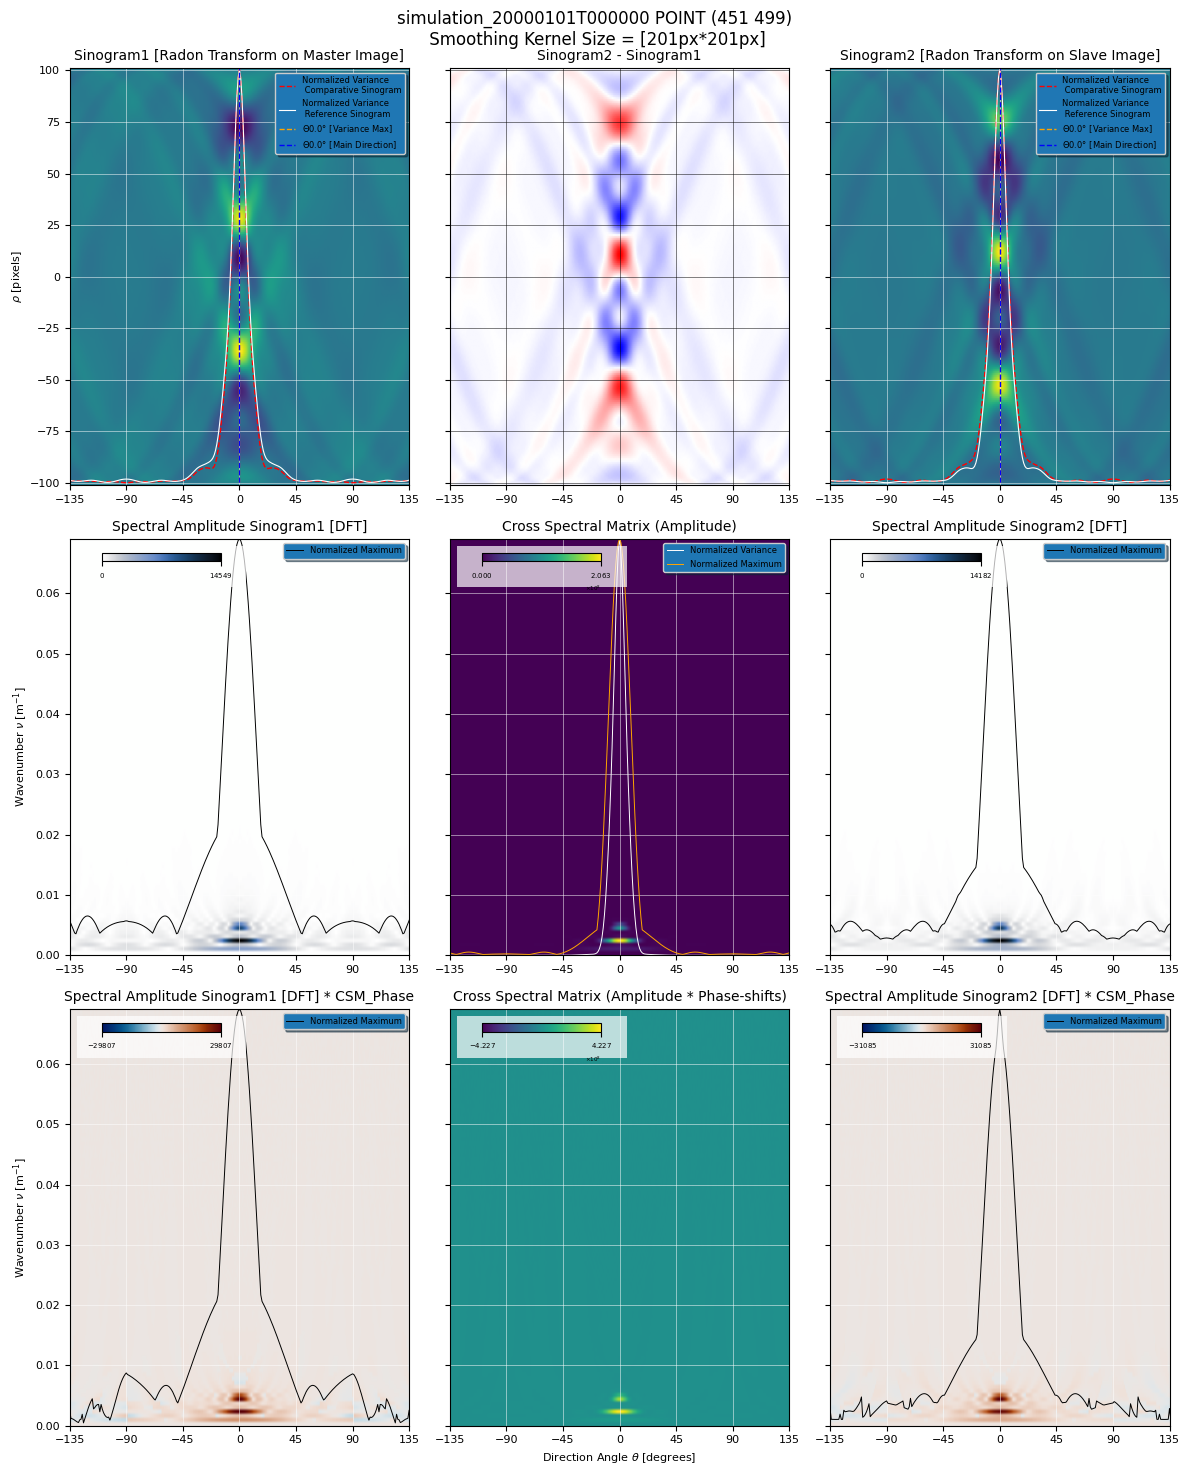

In [15]:
if False:
    build_dft_sinograms_spectral_analysis(local_estimator)
else:
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 15))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)


    first_radon_transform = local_estimator.radon_transforms[0]
    second_radon_transform = local_estimator.radon_transforms[1]

    # First Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
    sinogram1 = np.empty((nb_samples, len(selected_directions)))
    sinogram2 = np.empty((nb_samples, len(selected_directions)))
    directions1 = selected_directions
    directions2 = selected_directions

    for index, direction in enumerate(selected_directions):
        sinogram1[:, index] = first_radon_transform[direction]
        sinogram2[:, index] = second_radon_transform[direction]

    radon_difference = (sinogram2 / np.max(np.abs(sinogram2))) - \
        (sinogram1 / np.max(np.abs(sinogram1)))

    # get main direction
    estimations = local_estimator.bathymetry_estimations
    sorted_estimations_args = estimations.argsort_on_attribute(
        local_estimator.final_estimations_sorting)
    main_direction = estimations.get_estimations_attribute('direction')[
        sorted_estimations_args[0]]

    build_sinogram_display(
        axs[0, 0], 'Sinogram1 [Radon Transform on Master Image]',
        sinogram1, selected_directions, sinogram2, plt_min, plt_max, main_direction, abscissa=False)
    build_sinogram_difference_display(
        axs[0, 1], 'Sinogram2 - Sinogram1', radon_difference, selected_directions, plt_min, plt_max,
        abscissa=False, cmap='bwr')
    build_sinogram_display(
        axs[0, 2], 'Sinogram2 [Radon Transform on Slave Image]', sinogram2, selected_directions, sinogram1,
        plt_min, plt_max, main_direction, ordonate=False, abscissa=False)


    # Second Plot line = Spectral Amplitude of Sinogram1 [after DFT] / CSM Amplitude /
    # Spectral Amplitude of Sinogram2 [after DFT]
    sino1_fft = get_sinograms_standard_dfts(first_radon_transform, selected_directions)
    sino2_fft = get_sinograms_standard_dfts(second_radon_transform, selected_directions)        
    kfft = local_estimator._metrics['kfft']
    csm_phase, _, _ = local_estimator._cross_correl_spectrum(sino1_fft, sino2_fft)

    build_sinogram_spectral_display(
        axs[1, 0],
        'Spectral Amplitude Sinogram1 [DFT]',
        np.abs(sino1_fft),
        directions1,
        kfft,
        plt_min,
        plt_max,
        abscissa=False,
        cmap='cmc.oslo_r')
    build_correl_spectrum_matrix(
        axs[1, 1],
        local_estimator,
        sino1_fft,
        sino2_fft,
        kfft,
        plt_min,
        plt_max,
        'amplitude',
        'Cross Spectral Matrix (Amplitude)',
        directions=directions1)
    build_sinogram_spectral_display(
        axs[1, 2],
        'Spectral Amplitude Sinogram2 [DFT]',
        np.abs(sino2_fft),
        directions2,
        kfft,
        plt_min,
        plt_max,
        ordonate=False,
        abscissa=False,
        cmap='cmc.oslo_r')

    # Third Plot line = Spectral Amplitude of Sinogram1 [after DFT] * CSM Phase /
    # CSM Amplitude * CSM Phase / Spectral Amplitude of Sinogram2 [after DFT] * CSM Phase

    build_sinogram_spectral_display(
        axs[2, 0],
        'Spectral Amplitude Sinogram1 [DFT] * CSM_Phase',
        np.abs(sino1_fft) * csm_phase,
        selected_directions,
        kfft,
        plt_min,
        plt_max,
        abscissa=False,
        cmap='cmc.vik')
    build_correl_spectrum_matrix(
        axs[2, 1],
        local_estimator,
        sino1_fft,
        sino2_fft,
        kfft,
        plt_min,
        plt_max,
        'phase',
        'Cross Spectral Matrix (Amplitude * Phase-shifts)',
        directions=directions1)
    build_sinogram_spectral_display(
        axs[2, 2],
        'Spectral Amplitude Sinogram2 [DFT] * CSM_Phase',
        np.abs(sino2_fft) * csm_phase,
        selected_directions,
        kfft,
        plt_min,
        plt_max,
        ordonate=False,
        abscissa=False,
        cmap='cmc.vik')
    plt.tight_layout()

## Display polar image

ARROWS [(0.0, 437043740.5502732)]
-->ARROW SIGNING THE MAX ENERGY [DFN, ENERGY, WAVELENGTH]]= (270.0, 437043740.5502732, 136.07621106623083)
MAIN DIRECTION 0.0
DIRECTION FROM NORTH 270.0
DELTA TIME 3.0
DELTA PHASE 2.047244075785284


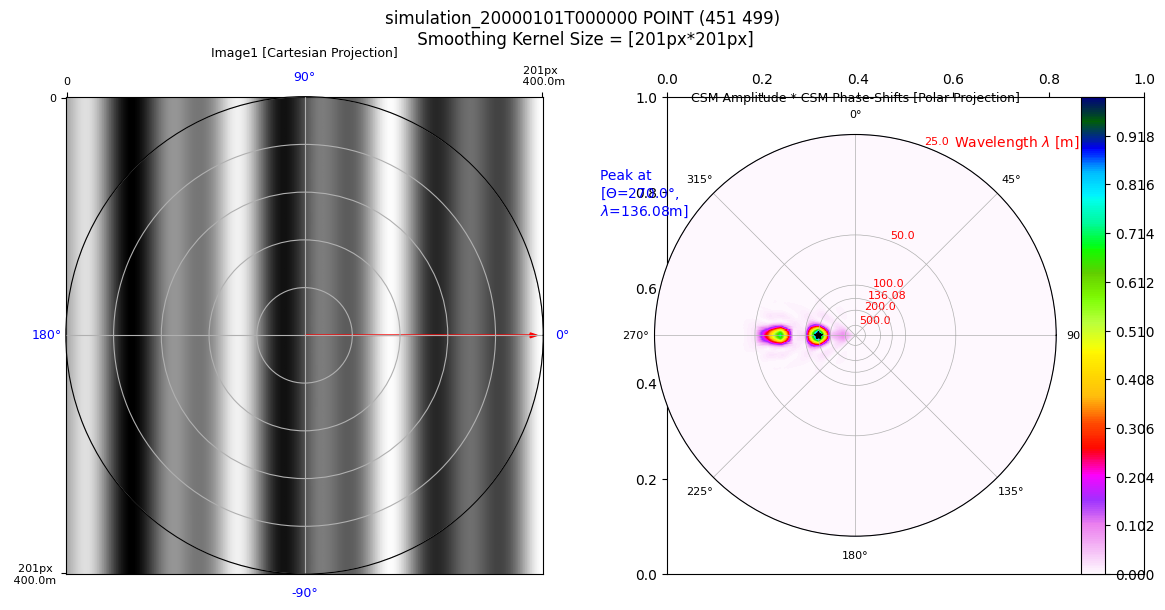

In [ ]:
from s2shores.bathy_debug.spatial_dft_wave_fields_display import build_polar_images_dft
from s2shores.bathy_debug.waves_image_display import build_display_waves_image
from s2shores.bathy_debug.polar_display import build_polar_display

if False:
    build_polar_images_dft(local_estimator)
else:
    nrows = 1
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    estimations = local_estimator.bathymetry_estimations
    best_estimation_idx = estimations.argsort_on_attribute(
        local_estimator.final_estimations_sorting)[0]
    main_direction = estimations.get_estimations_attribute('direction')[best_estimation_idx]
    ener_max = estimations.get_estimations_attribute('energy_ratio')[best_estimation_idx]
    main_wavelength = estimations.get_estimations_attribute('wavelength')[best_estimation_idx]
    dir_max_from_north = (270 - main_direction) % 360
    arrows = [(wfe.direction, wfe.energy_ratio) for wfe in estimations]

    print('ARROWS', arrows)
    first_image = local_estimator.ortho_sequence[0]

    # First Plot line = Image1 / pseudoRGB / Image2
    build_display_waves_image(
        fig,
        axs[0],
        'Image1 [Cartesian Projection]',
        first_image.original_pixels,
        resolution=first_image.resolution,
        subplot_pos=[nrows, ncols, 1],
        directions=arrows,
        cmap='gray')

    csm_phase, spectrum_amplitude, sinograms_correlation_fft = \
        local_estimator._cross_correl_spectrum(sino1_fft, sino2_fft)
    csm_amplitude = np.abs(sinograms_correlation_fft)

    # Retrieve arguments corresponding to the arrow with the maximum energy
    arrow_max = (dir_max_from_north, ener_max, main_wavelength)

    print('-->ARROW SIGNING THE MAX ENERGY [DFN, ENERGY, WAVELENGTH]]=', arrow_max)
    polar = csm_amplitude * csm_phase

    # set negative values to 0 to avoid mirror display
    polar[polar < 0] = 0
    build_polar_display(
        fig,
        axs[1],
        'CSM Amplitude * CSM Phase-Shifts [Polar Projection]',
        local_estimator,
        polar,
        first_image.resolution,
        dir_max_from_north,
        main_wavelength,
        subplot_pos=[1, 2, 2],
        directions=selected_directions,
        nb_wavenumbers=sinogram1.shape[0])
    plt.tight_layout()